<h2>Fazendo web scraping com IMDb</h2>

In [1]:
# ! pip install bs4

In [2]:
import requests 
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# url com a listagem de filmes de Al Pacino
url = 'https://www.imdb.com/name/nm0000199/?ref_=nm_ql_4'

# fazendo a conexão
con = requests.get(url)
con.status_code

# criando objeto beautifulsoup
# o conteúdo html da página
soup = BeautifulSoup(con.content,"html.parser")

In [4]:
# print(soup.prettify())

In [5]:
# pegando tudo relacionado a filmes
nomeFilmes = [tag.find('a') for tag in soup.findAll('div', class_='filmo-row')]

In [6]:
# tratando caracteres indesejados
anoFilmes = [tag.find('span') for tag in soup.findAll('div', class_='filmo-row')]

anos = []
for num in anoFilmes:
    id = anoFilmes.index(num)
    c = re.findall('\d+', str(anoFilmes[id]))
    c = re.sub("\['", '', str(c))
    c = re.sub("\']",'',str(c))
    c = re.sub("\'\,",' -',str(c))
    c = re.sub("\ '",' ',str(c))
    anos.append(c)

In [7]:
# usando re para pegar tudo o que está entre "" para gerar o link do filme
linkPart = 'http://imdb.com'
linksFilmes = []
for num in nomeFilmes:
    id = nomeFilmes.index(num)
    a = re.findall(r'"(.*?)"', str(nomeFilmes[id]))
    a = re.sub("\['", '', str(a))
    a = re.sub("\']", '', str(a))
    a = linkPart + str(a)
    linksFilmes.append(a)

In [8]:
titulosFilmes = []
for num in nomeFilmes:
    id = nomeFilmes.index(num)
    b = re.findall(r'>(.*?)<', str(nomeFilmes[id]))
    b = re.sub("\['", '', str(b))
    b = re.sub("\']", '', str(b))
    b = re.sub('\["', '', str(b))
    b = re.sub('\"]', '', str(b))
    titulosFilmes.append(b)

In [9]:
def pegaAno(soup):
    anoFilme = [tag.find('a') for tag in soup2.findAll('h1', itemprop='name')]
    anoFilme = re.findall(r'>(.*?)<', str(anoFilme))
    if len(anoFilme):
        return int(anoFilme[0])
    else:
        return None

In [10]:
def pegaNotaIMDB(link):
    for i in link:
        con2 = requests.get(link)
        soup2= BeautifulSoup(con2.content, "html.parser")
        ratFilme = [tag.find('span', itemprop='ratingValue') for tag in soup2.findAll('div', class_='ratingValue')]
        ratFilme = re.findall(r'>(.*?)<', str(ratFilme))
        if len(ratFilme):
            return str(ratFilme[0])
        else:
            return None

In [11]:
#Genre
def pegaGenero(soup):
    genFilme = [tag.findAll('a') for tag in soup2.findAll('div', class_='subtext')]
    genFilme = re.findall(r'>(.*?)<', str(genFilme))
    genFilmes = ''.join(genFilme)
    genFilmes = genFilmes[:-2]
    return genFilmes

In [12]:
# funções para pegar informações do filme
qtdFilmAct = 61
film = {}
listaFilmes = []

for i in range(qtdFilmAct):
    con2 = requests.get(linksFilmes[i])
    soup2 = BeautifulSoup(con2.content, "html.parser")
    con2.close()

    film['Titulo']            = titulosFilmes[i]
    film['Link']              = linksFilmes[i]
    film['Ano']               = anos[i]
    film['Genero']            = pegaGenero(linksFilmes[i])
    film['Nota IMDB']         = pegaNotaIMDB(linksFilmes[i])
    listaFilmes.append(film.copy())

In [14]:
# separando o dataframe em 2: um com dados de filmes nao lançados, e outro de filmes lançados
dffilme = pd.DataFrame(listaFilmes, columns=['Titulo', 'Link', 'Ano', 'Genero', 'Nota IMDB'])
dffilme = dffilme.iloc[5:,:]
dfnaolancados = dffilme.iloc[:5,:]

In [15]:
dffilme.head()

,Titulo,Link,Ano,Genero,Nota IMDB
5,Paterno,http://imdb.com/title/tt2388986/?ref_=nm_flmg_...,2018,"Biography, Crime, Sport",6.5
6,Letras da Morte,http://imdb.com/title/tt3011960/?ref_=nm_flmg_...,2017,"Crime, Mystery, Thriller",5.2
7,The Pirates of Somalia,http://imdb.com/title/tt5126922/?ref_=nm_flmg_...,2017,"Biography, Drama",6.8
8,Má Conduta,http://imdb.com/title/tt3658772/?ref_=nm_flmg_...,2016,"Crime, Drama, Mystery",5.3
9,Não Olhe para Trás,http://imdb.com/title/tt1772288/?ref_=nm_flmg_...,2015,"Biography, Comedy, Drama",7.0


In [16]:
# verificando se há dados nulos
dffilme.isna().sum()

Titulo       0
Link         0
Ano          0
Genero       0
Nota IMDB    0
dtype: int64

In [17]:
dffilme.dtypes

Titulo       object
Link         object
Ano          object
Genero       object
Nota IMDB    object
dtype: object

In [18]:
# transformando a nota do IMDB em float, para poder plotar os gráficos
dffilme['Nota IMDB'] = dffilme['Nota IMDB'].apply(pd.to_numeric, downcast='float', errors='coerce')

In [19]:
# verificando o filme com a maior nota no IMDB atuado pelo Al Pacino
dffilme.loc[dffilme['Nota IMDB'].idxmax()]

Titulo                   The Godfather: A Novel for Television
Link         http://imdb.com/title/tt0809488/?ref_=nm_flmg_...
Ano                                                       1977
Genero                                  Crime, Drama, Thriller
Nota IMDB                                                  9.5
Name: 51, dtype: object

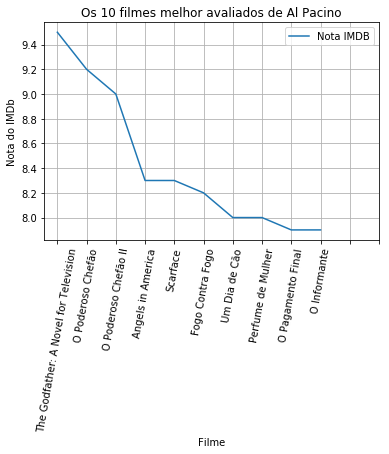

In [20]:
# overall do top 10 jogadores do fifa
top10 = dffilme.sort_values(ascending = False, by=['Nota IMDB']).head(10)
nomes = []
nomes = top10['Titulo'].values
def best_movies(axes = None):
    top10.plot(kind="line" , x="Titulo", y ="Nota IMDB", ax=axes)
    plt.xlabel("Filme")
    plt.ylabel("Nota do IMDb")
    plt.xticks(np.arange(12), nomes[0:], rotation=80)
    plt.grid()
    plt.title("Os 10 filmes melhor avaliados de Al Pacino", fontsize=12)
best_movies()

In [21]:
generos = []
for item in dffilme['Genero']:
    new = item.split(", ")
    for x in new:
        generos.append(x)

In [22]:
genre = pd.DataFrame(generos, columns=['Genero'])
genre.head(5)

,Genero
0,Biography
1,Crime
2,Sport
3,Crime
4,Mystery


In [23]:
genre = genre.groupby(["Genero"]).size().reset_index(name='count')
genre = genre.rename(columns={'count': 'Qtd'})
genre.head(5)

,Genero,Qtd
0,Action,3
1,Adventure,1
2,Biography,9
3,Comedy,11
4,Crime,26


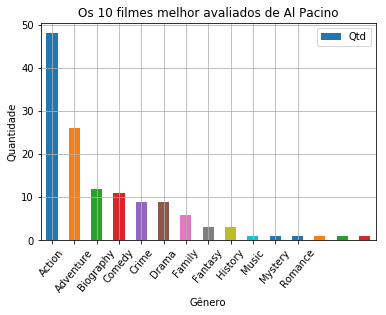

In [24]:
# overall do top 10 jogadores do fifa
nomes = genre['Genero']
genre = genre.sort_values(ascending=False, by=['Qtd'])
def dist_generos(axes = None):
    genre.plot(kind="bar" , x="Genero", y ="Qtd", ax=axes)
    plt.xlabel("Gênero")
    plt.ylabel("Quantidade")
    plt.xticks(np.arange(12), nomes[0:], rotation=50)
    plt.grid()
    plt.title("Os 10 filmes melhor avaliados de Al Pacino", fontsize=12)
dist_generos()

In [25]:
ano = pd.DataFrame(dffilme['Ano'], columns=['Ano'])
ano = ano.groupby(["Ano"]).size().reset_index(name='count')
ano = ano.rename(columns={'count': 'Qtd'})
ano.head()

,Ano,Qtd
0,1968,1
1,1969,1
2,1971,1
3,1972,1
4,1973,2


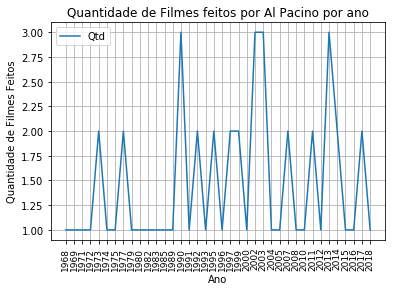

In [26]:
# quantidade de filmes por ano
anos = ano['Ano']
def filmes_ano(axes = None):
    ano.plot(kind="line" , x="Ano", y ="Qtd", ax=axes)
    plt.xlabel("Ano")
    plt.ylabel("Quantidade de Filmes Feitos")
    plt.xticks(ano.index, anos[0:], rotation='vertical', fontsize=9)
    plt.grid()
    plt.title("Quantidade de Filmes feitos por Al Pacino por ano", fontsize=12)
filmes_ano()